MNIST의 숫자이미지를 활용한 컴피티션으로  
기존 데이터와는 다르게 숫자위에 알파벳이 덮어 씌여져 있는 데이터이다.  
파일은 점수를 갱신할 때 같이 업데이트 할 예정이다.  

---

## 디렉토리 설정(colab 기준)

In [1]:
# colab내에서 사용하는 디렉토리 지정

from google.colab import drive
drive.mount("/gdrive", force_remount=True)
%cd /gdrive/My Drive/dacon_mnist

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/dacon_mnist


## 필요 라이브러리

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 

import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.utils import to_categorical
from keras import regularizers # regularizer(L2)

from tensorflow.keras.preprocessing.image import ImageDataGenerator # 이미지 증식
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정


from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 데이터 불러오기

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

## 데이터 살펴보기

In [16]:
display(train.info(),train.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048 entries, 0 to 2047
Columns: 787 entries, id to 783
dtypes: int64(786), object(1)
memory usage: 12.3+ MB


None

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2


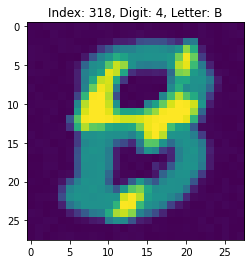

In [9]:
# train 및 test 데이터를 이미지로 시각화 한 것
# 알파벳과 숫자가 보이지만 숫자부분은 겹친 부분을 제외하고는 나오지 않음

idx = 318
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

알파벳 B안에 숫자 4가 보임

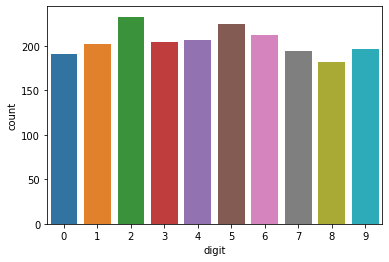

In [6]:
# train데이터의 digit 분포
sns.countplot(train.digit)
plt.show()

숫자의 분포는 나름 균일한 것으로 보임

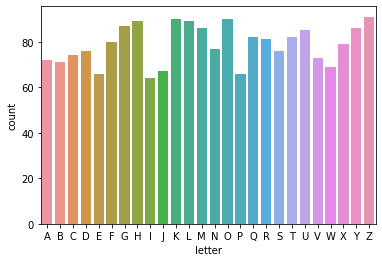

In [8]:
# train 데이터의 letter 분포
sns.countplot(train.letter.sort_values())
plt.show()

## 모델만들기

In [ ]:
def make_model():
  
  input_image = Input(shape = (28,28,1))

  bn1_1 = layers.BatchNormalization()(input_image)
  conv1_1 = layers.Conv2D(64, kernel_size = 5, padding = 'same', activation = 'relu', kernel_regularizer = regularizers.l2(0.001))(bn1_1)
  bn1_2 = layers.BatchNormalization()(conv1_1)
  conv1_2 = layers.Conv2D(64, kernel_size = 2, padding='same')(bn1_2)
  mp1 = layers.MaxPooling2D((2, 2))(conv1_2)  
  
  conv1_3 = layers.Conv2D(64, kernel_size = 1, strides = 2, padding = 'same')(input_image)

  add1 = layers.Add()([mp1, conv1_3])
  relu1 = layers.ReLU()(add1)
  do1 = layers.Dropout(0.5)(relu1)

  bn2_1 = layers.BatchNormalization()(do1)
  conv2_1 = layers.Conv2D(128, kernel_size = 2, padding = 'same', activation = 'relu', kernel_regularizer = regularizers.l2(0.001))(bn2_1)
  bn2_2 = layers.BatchNormalization()(conv2_1)
  conv2_2 = layers.Conv2D(128, kernel_size = 2, padding = 'same')(bn2_2)
  mp2 = layers.MaxPooling2D((2, 2))(conv2_2)

  conv2_3 = layers.Conv2D(128, kernel_size = 1, strides = 2, padding = 'same')(do1)

  add2 = layers.Add()([mp2, conv2_3])
  relu2 = layers.ReLU()(add2)
  do2 = layers.Dropout(0.5)(relu2)

  conv3 = layers.Conv2D(256, kernel_size = 2 , padding = 'same', activation = 'relu', kernel_regularizer = regularizers.l2(0.001))(do2)
  bn3 = layers.BatchNormalization()(conv3)
  
  flat = layers.Flatten()(bn3)

  bn4 = layers.BatchNormalization()(flat)
  dn1 = layers.Dense(1028, activation = 'relu', kernel_regularizer = regularizers.l2(0.001))(bn4)
  bn5 = layers.BatchNormalization()(dn1)

  output_tensor = layers.Dense(10, activation='softmax')(bn5)
  
  model = Model(inputs = input_image, outputs = output_tensor)

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
  
  return model

In [ ]:
# 모델 구조 살펴보기
make_model().summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, 28, 28, 1)    4           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 28, 28, 64)   1664        batch_normalization_35[0][0]     
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 28, 28, 64)   256         conv2d_35[0][0]                  
______________________________________________________________________________________

## 모델학습
- random seed N개를 이용한 seed_ensemble
- test(20480)에 비해 train(2048)의 데이터 양이 작아 validation없이 학습
- 

Model fitting 

Epoch 1/100
64/64 [==============================] - 26s 414ms/step - loss: 7.3023 - accuracy: 0.1851
Epoch 2/100
64/64 [==============================] - 27s 418ms/step - loss: 5.2413 - accuracy: 0.2861
Epoch 3/100
64/64 [==============================] - 28s 431ms/step - loss: 4.7078 - accuracy: 0.3340
Epoch 4/100
64/64 [==============================] - 26s 413ms/step - loss: 4.4057 - accuracy: 0.3921
Epoch 5/100
64/64 [==============================] - 26s 412ms/step - loss: 4.1164 - accuracy: 0.4053
Epoch 6/100
64/64 [==============================] - 26s 413ms/step - loss: 3.9167 - accuracy: 0.4189
Epoch 7/100
64/64 [==============================] - 26s 413ms/step - loss: 3.6716 - accuracy: 0.4565
Epoch 8/100
64/64 [==============================] - 27s 414ms/step - loss: 3.4700 - accuracy: 0.4722
Epoch 9/100
64/64 [==============================] - 27s 418ms/step - loss: 3.2963 - accuracy: 0.4951
Epoch 10/100
64/64 [==============================] - 26s 412ms/st

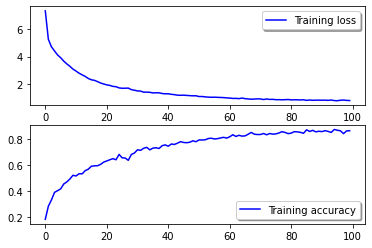

Train accuracy=0.87598, 
Model fitting 

Epoch 1/100
64/64 [==============================] - 26s 409ms/step - loss: 7.1089 - accuracy: 0.2012
Epoch 2/100
64/64 [==============================] - 26s 411ms/step - loss: 5.1833 - accuracy: 0.2866
Epoch 3/100
64/64 [==============================] - 26s 411ms/step - loss: 4.6286 - accuracy: 0.3564
Epoch 4/100
64/64 [==============================] - 27s 423ms/step - loss: 4.3226 - accuracy: 0.3926
Epoch 5/100
64/64 [==============================] - 26s 410ms/step - loss: 4.0336 - accuracy: 0.4326
Epoch 6/100
64/64 [==============================] - 26s 411ms/step - loss: 3.8510 - accuracy: 0.4438
Epoch 7/100
64/64 [==============================] - 26s 411ms/step - loss: 3.6132 - accuracy: 0.4644
Epoch 8/100
64/64 [==============================] - 26s 410ms/step - loss: 3.4623 - accuracy: 0.4775
Epoch 9/100
64/64 [==============================] - 27s 414ms/step - loss: 3.2316 - accuracy: 0.4956
Epoch 10/100
64/64 [=====================

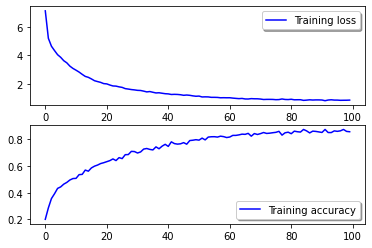

Train accuracy=0.87402, 
Model fitting 

Epoch 1/100
64/64 [==============================] - 30s 461ms/step - loss: 7.5106 - accuracy: 0.1982
Epoch 2/100
64/64 [==============================] - 26s 405ms/step - loss: 5.5538 - accuracy: 0.2910
Epoch 3/100
64/64 [==============================] - 26s 405ms/step - loss: 4.7575 - accuracy: 0.3594
Epoch 4/100
64/64 [==============================] - 26s 405ms/step - loss: 4.4624 - accuracy: 0.3867
Epoch 5/100
64/64 [==============================] - 26s 404ms/step - loss: 4.1658 - accuracy: 0.4214
Epoch 6/100
64/64 [==============================] - 26s 405ms/step - loss: 3.9529 - accuracy: 0.4463
Epoch 7/100
64/64 [==============================] - 26s 409ms/step - loss: 3.7341 - accuracy: 0.4526
Epoch 8/100
64/64 [==============================] - 26s 407ms/step - loss: 3.5560 - accuracy: 0.4717
Epoch 9/100
64/64 [==============================] - 26s 404ms/step - loss: 3.3557 - accuracy: 0.4937
Epoch 10/100
64/64 [=====================

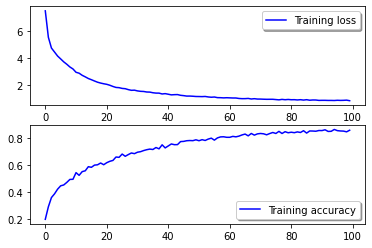

Train accuracy=0.86377, 
Model fitting 

Epoch 1/100
64/64 [==============================] - 26s 406ms/step - loss: 7.3709 - accuracy: 0.1821
Epoch 2/100
64/64 [==============================] - 26s 404ms/step - loss: 5.3040 - accuracy: 0.2681
Epoch 3/100
64/64 [==============================] - 26s 406ms/step - loss: 4.7138 - accuracy: 0.3608
Epoch 4/100
64/64 [==============================] - 26s 410ms/step - loss: 4.4005 - accuracy: 0.3896
Epoch 5/100
64/64 [==============================] - 26s 406ms/step - loss: 4.1315 - accuracy: 0.4102
Epoch 6/100
64/64 [==============================] - 26s 406ms/step - loss: 3.8843 - accuracy: 0.4473
Epoch 7/100
64/64 [==============================] - 26s 404ms/step - loss: 3.6724 - accuracy: 0.4712
Epoch 8/100
64/64 [==============================] - 26s 406ms/step - loss: 3.4603 - accuracy: 0.4849
Epoch 9/100
64/64 [==============================] - 26s 403ms/step - loss: 3.2876 - accuracy: 0.5034
Epoch 10/100
64/64 [=====================

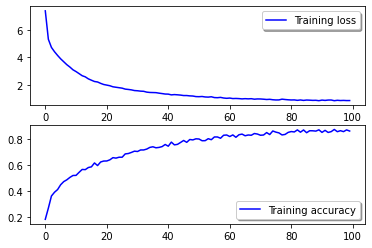

Train accuracy=0.87109, 
Model fitting 

Epoch 1/100
64/64 [==============================] - 27s 416ms/step - loss: 7.3281 - accuracy: 0.1997
Epoch 2/100
64/64 [==============================] - 26s 409ms/step - loss: 5.3486 - accuracy: 0.2734
Epoch 3/100
64/64 [==============================] - 30s 464ms/step - loss: 4.7566 - accuracy: 0.3296
Epoch 4/100
64/64 [==============================] - 27s 419ms/step - loss: 4.3574 - accuracy: 0.4009
Epoch 5/100
64/64 [==============================] - 26s 406ms/step - loss: 4.1069 - accuracy: 0.4292
Epoch 6/100
64/64 [==============================] - 26s 408ms/step - loss: 3.8957 - accuracy: 0.4341
Epoch 7/100
64/64 [==============================] - 26s 409ms/step - loss: 3.6916 - accuracy: 0.4453
Epoch 8/100
64/64 [==============================] - 26s 408ms/step - loss: 3.4689 - accuracy: 0.4668
Epoch 9/100
64/64 [==============================] - 26s 407ms/step - loss: 3.2908 - accuracy: 0.4829
Epoch 10/100
64/64 [=====================

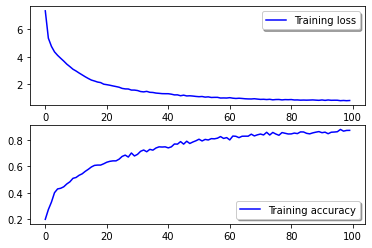

Train accuracy=0.87842, 
Model fitting 

Epoch 1/100
64/64 [==============================] - 27s 421ms/step - loss: 7.2335 - accuracy: 0.2139
Epoch 2/100
64/64 [==============================] - 27s 416ms/step - loss: 5.3225 - accuracy: 0.2793
Epoch 3/100
64/64 [==============================] - 27s 417ms/step - loss: 4.6692 - accuracy: 0.3574
Epoch 4/100
64/64 [==============================] - 27s 415ms/step - loss: 4.3595 - accuracy: 0.4062
Epoch 5/100
64/64 [==============================] - 27s 416ms/step - loss: 4.1074 - accuracy: 0.4170
Epoch 6/100
64/64 [==============================] - 27s 428ms/step - loss: 3.9161 - accuracy: 0.4243
Epoch 7/100
64/64 [==============================] - 26s 414ms/step - loss: 3.6834 - accuracy: 0.4556
Epoch 8/100
64/64 [==============================] - 27s 417ms/step - loss: 3.4915 - accuracy: 0.4644
Epoch 9/100
64/64 [==============================] - 27s 420ms/step - loss: 3.2861 - accuracy: 0.4941
Epoch 10/100
64/64 [=====================

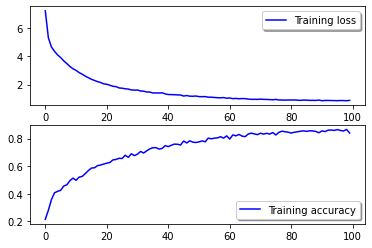

Train accuracy=0.86621, 
Model fitting 

Epoch 1/100
64/64 [==============================] - 27s 414ms/step - loss: 7.3081 - accuracy: 0.2036
Epoch 2/100
64/64 [==============================] - 30s 472ms/step - loss: 5.2807 - accuracy: 0.2900
Epoch 3/100
64/64 [==============================] - 26s 414ms/step - loss: 4.6591 - accuracy: 0.3506
Epoch 4/100
64/64 [==============================] - 27s 415ms/step - loss: 4.3972 - accuracy: 0.3833
Epoch 5/100
64/64 [==============================] - 27s 415ms/step - loss: 4.1286 - accuracy: 0.4316
Epoch 6/100
64/64 [==============================] - 26s 413ms/step - loss: 3.8885 - accuracy: 0.4531
Epoch 7/100
64/64 [==============================] - 26s 414ms/step - loss: 3.6387 - accuracy: 0.4575
Epoch 8/100
64/64 [==============================] - 27s 417ms/step - loss: 3.4359 - accuracy: 0.4883
Epoch 9/100
64/64 [==============================] - 27s 428ms/step - loss: 3.3203 - accuracy: 0.4839
Epoch 10/100
64/64 [=====================

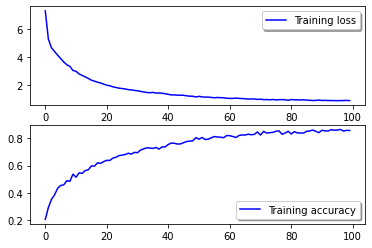

Train accuracy=0.86621, 
Model fitting 

Epoch 1/100
64/64 [==============================] - 27s 418ms/step - loss: 7.4048 - accuracy: 0.1958
Epoch 2/100
64/64 [==============================] - 26s 411ms/step - loss: 5.3891 - accuracy: 0.2954
Epoch 3/100
64/64 [==============================] - 26s 409ms/step - loss: 4.7361 - accuracy: 0.3569
Epoch 4/100
64/64 [==============================] - 26s 411ms/step - loss: 4.4002 - accuracy: 0.4053
Epoch 5/100
64/64 [==============================] - 26s 411ms/step - loss: 4.1643 - accuracy: 0.4185
Epoch 6/100
64/64 [==============================] - 26s 407ms/step - loss: 3.9192 - accuracy: 0.4478
Epoch 7/100
64/64 [==============================] - 26s 409ms/step - loss: 3.7030 - accuracy: 0.4614
Epoch 8/100
64/64 [==============================] - 26s 408ms/step - loss: 3.5381 - accuracy: 0.4546
Epoch 9/100
64/64 [==============================] - 26s 408ms/step - loss: 3.3654 - accuracy: 0.4810
Epoch 10/100
64/64 [=====================

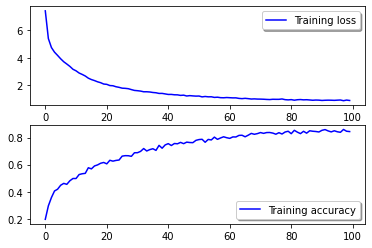

Train accuracy=0.86035, 
Model fitting 

Epoch 1/100
64/64 [==============================] - 26s 410ms/step - loss: 7.3781 - accuracy: 0.1963
Epoch 2/100
64/64 [==============================] - 28s 431ms/step - loss: 5.2982 - accuracy: 0.2793
Epoch 3/100
64/64 [==============================] - 27s 420ms/step - loss: 4.7421 - accuracy: 0.3535
Epoch 4/100
64/64 [==============================] - 26s 412ms/step - loss: 4.3809 - accuracy: 0.3828
Epoch 5/100
64/64 [==============================] - 27s 415ms/step - loss: 4.1655 - accuracy: 0.4150
Epoch 6/100
64/64 [==============================] - 26s 414ms/step - loss: 3.8841 - accuracy: 0.4404
Epoch 7/100
64/64 [==============================] - 27s 415ms/step - loss: 3.7096 - accuracy: 0.4453
Epoch 8/100
64/64 [==============================] - 27s 416ms/step - loss: 3.4997 - accuracy: 0.4692
Epoch 9/100
64/64 [==============================] - 27s 420ms/step - loss: 3.2924 - accuracy: 0.4990
Epoch 10/100
64/64 [=====================

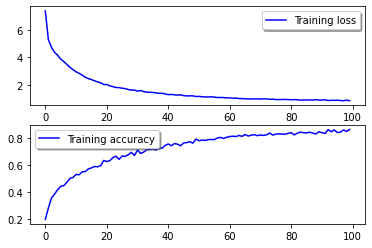

Train accuracy=0.86182, 
Model fitting 

Epoch 1/100
64/64 [==============================] - 27s 416ms/step - loss: 7.2388 - accuracy: 0.2061
Epoch 2/100
64/64 [==============================] - 27s 420ms/step - loss: 5.3010 - accuracy: 0.2925
Epoch 3/100
64/64 [==============================] - 28s 431ms/step - loss: 4.6613 - accuracy: 0.3652
Epoch 4/100
64/64 [==============================] - 27s 414ms/step - loss: 4.3812 - accuracy: 0.3975
Epoch 5/100
64/64 [==============================] - 26s 411ms/step - loss: 4.1274 - accuracy: 0.4062
Epoch 6/100
64/64 [==============================] - 26s 411ms/step - loss: 3.9049 - accuracy: 0.4316
Epoch 7/100
64/64 [==============================] - 26s 413ms/step - loss: 3.6558 - accuracy: 0.4653
Epoch 8/100
64/64 [==============================] - 30s 463ms/step - loss: 3.4741 - accuracy: 0.4731
Epoch 9/100
64/64 [==============================] - 26s 411ms/step - loss: 3.2839 - accuracy: 0.4937
Epoch 10/100
64/64 [=====================

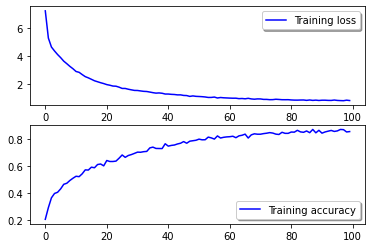

Train accuracy=0.87158, 



In [ ]:
N = 10
preds = []
accs = []
pred_models = []
SEEDs = []

for i in tqdm(range(N)):
  # random seed 설정 및 저장
  SEED = np.random.randint(1, 10000)
  random.seed(SEED)
  np.random.seed(SEED)
  tf.random.set_seed(SEED)
  
  X_train = (train.iloc[:,3:] / 255.).values.reshape(-1, 28, 28, 1)
  y_train = to_categorical(train['digit'].values)
  X_test = (test.iloc[:,2:] / 255.).values.reshape(-1, 28, 28, 1)
  
  annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

  # 이미지 증식 사용
  datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False, 
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False, 
        vertical_flip=False)

  # 에포크 설정 
  # 일반적으로 많으면 많을수록 정확도 증가
  epochs = 100

  # 모델 구축하기
  model = make_model()
  
  print('Model fitting \n')
  
  history = model.fit(
      datagen.flow(X_train, y_train, batch_size=32),
      epochs=epochs, 
      steps_per_epoch = X_train.shape[0]//32,
      callbacks=[annealer], 
      verbose = 1
  )

  print("Make predict \n")
  
  acc = max(history.history['accuracy'])
  
  # test set 모델로 예측
  results = model.predict(X_test)

  # Fitting이 끝난 후, 사용 시드, 예측 모델, 결과, 정확도를 저장
  SEEDs.append(SEED)
  pred_models.append(model)
  preds.append(results)        
  accs.append(acc) 
  
  #학습결과 시각화하기
  print(f'CNN learning curve {i+1}/{N} \n')
  
  fig, ax = plt.subplots(2,1)
  ax[0].plot(history.history['loss'], color='b', label="Training loss")
  legend = ax[0].legend(loc='best', shadow=True)

  ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
  legend = ax[1].legend(loc='best', shadow=True)
  plt.show()

  print(
      f"Train accuracy={max(history.history['accuracy']):.5f}, " 
  )

## 모델 및 결과 저장

In [ ]:
# accuracy 0.87이상인 결과물 추출
threshold = 0.87

threshold_SEEDs = np.array(SEEDs)[np.array(accs)>threshold]
threshold_pred_models = np.array(pred_models)[np.array(accs)>threshold]
threshold_accs = np.array(accs)[np.array(accs)>threshold]
threshold_preds = np.array(preds)[np.array(accs)>threshold]

In [ ]:
display(threshold_SEEDs)
display(threshold_accs)

array([2468, 5227, 4491, 4489, 6077])

array([0.87597656, 0.87402344, 0.87109375, 0.87841797, 0.87158203])

In [ ]:
# 실행시간 및 SEED를 제목으로 모델 및 가중치 저장

for i, model in enumerate(threshold_pred_models):
  now_datetime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
  model.save_weights(f'params{threshold_SEEDs[i]}_{now_datetime}.h5')

  model_json = model.to_json()
  with open(f"model{threshold_SEEDs[i]}_{now_datetime}.json", "w") as json_file : 
      json_file.write(model_json)
  print(now_datetime,threshold_SEEDs[i])

2020-08-18 10:45:46 2468
2020-08-18 10:45:46 5227
2020-08-18 10:45:46 4491
2020-08-18 10:45:47 4489
2020-08-18 10:45:47 6077


In [ ]:
# 뽑힌 모델의 결과들을 합쳐 하나의 결과로 통합
def sum_preds(preds):
   answer = np.zeros((test.shape[0],10))
   
   for i in range(len(preds)):
    for j in range(len(preds[i])):
      for k in range(len(preds[i][j])):
        answer[j][k] += preds[i][j][k]

   return answer
   
results = sum_preds(threshold_preds)

In [ ]:
# 예측값을 확률에서 숫자로 변형
num_pred = np.argmax(results,axis = 1)
submission.digit = num_pred

In [ ]:
# submission_16 결과
submission.digit.value_counts()

6    2484
9    2471
1    2196
0    2145
4    2032
8    1982
3    1886
2    1866
7    1814
5    1604
Name: digit, dtype: int64

In [ ]:
submission.digit = num_pred
submission.to_csv('submission_16.csv', index=False)
submission

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,6


## 결과 및 고려사항
1.   결과
> - letter를 input으로 받는 다중입력모델을 만들어 봤으나 성능이 저조함  
> - validation set을 만들어서 과적합을 막으려 했으나 데이터가 적어 성능저하로 이어짐  
> - 무작위적으로 두개의 이미지를 섞어 새로운 이미지를 만들어 보았으나 기존 이미지와의 과적합 문제로 성능이 나오지 않음  
> - activation function을 elu, prelu, leakyrelu로 변경했으나 relu보다 성능이 좋지 않음  
> - 모델의 수와 epochs의 크기가 일반적으로 accuracy와 비례하는 것으로 나옴  
> - 은닉층과 노드는 수가 많아질수록 학습 성능과 시간이 늘어나지만 과적합을 일으킨다  
> - 과적합을 줄이기 위해 L2규제화와 드롭아웃층을 쓴 것은 큰 효과가 있었다.  
> - 주로 2,8,9,0 등의 숫자가 많이 나오는데 test데이터가 치중된 것인지 특징추출이 숫자위의 원형에 집중되어 뽑혀서 그런 것인지 가늠이 불가함  
> - 잔차연결(residual connection)은 성능을 올리는데 기여함(0.85->0.86)  
  
2.   고려사항
> - letter 필드를 사용하는 방법을 조금더 생각해 볼 필요가 있음(다중입력도 다시 시도)  
> - callbacks를 설정, 학습시간을 조금 더 줄여보도록 노력  
> - Inception 구조를 이용해서 모델 만들어보기  
> - 사전학습된 모델을 가중치 초기화한 후 돌려보기